In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

plt.style.use('seaborn')


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

In [146]:
# Загрузка данных
df = pd.read_csv('weatherAUS.csv')

In [147]:
#Удаление пустых колонок
df= df.drop(['Date','Evaporation','Sunshine','Cloud9am','Cloud3pm'], axis= 1)


In [148]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


In [149]:
nan = df.loc[:, df.isnull().any()].copy()
nan

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118831,6.8,21.4,0.0,ENE,22.0,NE,WSW,9.0,9.0,82.0,45.0,1020.4,1017.8,13.8,20.6,No,No
118832,8.6,23.6,0.0,ENE,28.0,NE,ESE,13.0,9.0,65.0,37.0,1023.9,1022.3,16.3,22.0,No,No
118833,8.0,24.9,0.0,ENE,37.0,NE,E,22.0,11.0,62.0,29.0,1025.6,1021.8,15.1,24.2,No,No
118834,10.2,26.6,0.0,S,33.0,ENE,SSE,17.0,13.0,51.0,28.0,1023.4,1020.4,16.3,26.3,No,No


In [150]:
df = df.dropna(subset=['RainTomorrow'])

In [151]:
df['RainToday'].replace({'Yes': 1, 'No' : 0}, inplace=True)

In [152]:
df['RainTomorrow'].replace({'Yes': 1, 'No' : 0}, inplace=True)

In [153]:
list_colums = df.columns.to_series().groupby(df.dtypes).groups
list_colums = {k.name: v for k, v in list_colums.items()}
list_colums

{'float64': Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
        'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
        'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday'],
       dtype='object'),
 'int64': Index(['RainTomorrow'], dtype='object'),
 'object': Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')}

In [154]:
col_with_nans = df.select_dtypes(include=['float64'])
list(col_with_nans.columns)

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

In [155]:
#Удаление NAN

df['MinTemp'].fillna(df['MinTemp'].mean(), inplace=True)
df['MaxTemp'].fillna(df['MaxTemp'].mean(), inplace=True)
df['Rainfall'].fillna(df['Rainfall'].mean(), inplace=True)
df['WindGustSpeed'].fillna(df['WindGustSpeed'].mean(), inplace=True)
df['WindSpeed9am'].fillna(df['WindSpeed9am'].mean(), inplace=True)
df['WindSpeed3pm'].fillna(df['WindSpeed3pm'].mean(), inplace=True)
df['Humidity9am'].fillna(df['Humidity9am'].mean(), inplace=True)
df['Humidity3pm'].fillna(df['Humidity3pm'].mean(), inplace=True)
df['Pressure9am'].fillna(df['Pressure9am'].mean(), inplace=True)
df['Pressure3pm'].fillna(df['Pressure3pm'].mean(), inplace=True)
df['Temp9am'].fillna(df['Temp9am'].mean(), inplace=True)
df['Temp3pm'].fillna(df['Temp3pm'].mean(), inplace=True)
df['RainToday'].fillna(df['RainToday'].mean(), inplace=True)

In [156]:
#One hot encoding
df_ext = pd.concat(
    [df.drop(list_colums['object'], axis=1),
     pd.get_dummies(df[list_colums
     ['object']], prefix=list_colums['object'])],
    axis=1)

In [157]:
df_ext

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Location_Adelaide,Location_Albany,Location_Albury,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_GoldCoast,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,...,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118830,8.0,22.1,0.0,26.0,17.0,13.0,75.0,44.0,1020.9,1018.0,15.2,21.4,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
118831,6.8,21.4,0.0,22.0,9.0,9.0,82.0,45.0,1020.4,1017.8,13.8,20.6,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
118832,8.6,23.6,0.0,28.0,13.0,9.0,65.0,37.0,1023.9,1022.3,16.3,22.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
118833,8.0,24.9,0.0,37.0,22.0,11.0,62.0,29.0,1025.6,1021.8,15.1,24.2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [158]:
#Конвертация в numpy
x, y = df_ext.drop(['RainTomorrow'], axis=1).to_numpy(), df['RainTomorrow'].to_numpy()
x.shape, y.shape


((115904, 101), (115904,))

In [159]:
#Разбивка на трейн/тест выборки
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=1)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((81132, 101), (34772, 101), (81132,), (34772,))

In [160]:
# Нормируем данные
from sklearn.preprocessing import RobustScaler
rb = RobustScaler()
rb.fit(x_train)
x_train_norm = rb.transform(x_train)
x_valid_norm = rb.transform(x_valid)

In [161]:
x_train.shape

(81132, 101)

In [162]:
input_shape = x_train_norm.shape[1]

In [186]:
#Создание модели
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(100, activation='relu'),
        layers.Dropout(.5,),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 15,301
Trainable params: 15,301
Non-trainable params: 0
_________________________________________________________________


In [187]:
#Компилирование модели
tf.keras.backend.clear_session()
model.compile(
    loss='binary_crossentropy',
    metrics=tf.keras.metrics.AUC(),
    optimizer=keras.optimizers.Adam(lr=0.001, amsgrad=True)
)



In [188]:
#Обучение модели
history = model.fit(x_train_norm, 
                    y_train, 
                    batch_size=5000, 
                    epochs=70, 
                    validation_data=(x_valid_norm, y_valid), 
                    verbose=0)

Text(0.5, 1.0, 'Loss')

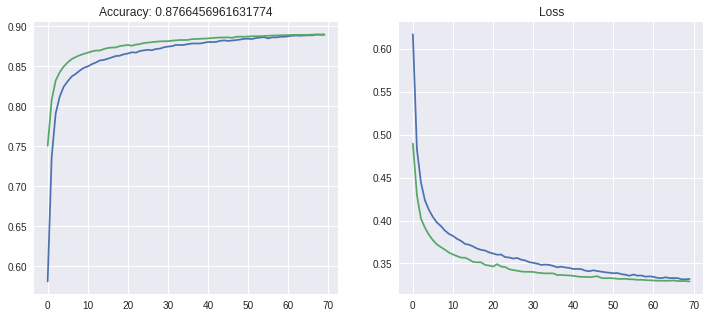

In [189]:
#Вывод графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['auc'])
ax1.plot(history.history['val_auc'])
ax1.set_title(f"Accuracy: {np.mean(history.history['val_auc'])}")

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Loss')